# Average words per sentence of different subreddits

### Background
An analysis of the average word count per sentence of comments from the most popular Subreddits. 

wps = words per sentence

### Subreddits analyzed (top 20 most subscribed as of April 2019):

### Contents
1. [Setup](#1.-Setup)
2. [Average Words Per Sentence for Comments](#2-Average-Words-Per-Sentence-for-Comments)
3. [Average wps for Submission](#3.-Average-wps-for-submission)
4. [Average wps for Subreddit](#4.-Average-wps-for-subreddit)
5. [Data Visualization](#5.-Data-Visualization)

## 1. Setup

In [1]:
import praw
import pandas as pd
import datetime
import json
import time
import string
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import defaultdict

In [2]:
# Load credfile and display when last updated
credfile = 'credfile.json'
credfile_prefix = ''

# Read credentials to a dictionary
with open(credfile) as fh:
    creds = json.loads(fh.read())

print(f"[{datetime.datetime.now()}]" + f"{credfile} {'.' * 10} is being used as credfile")

reddit = praw.Reddit(client_id=creds['client_id'],
                     client_secret=creds['client_secret'],
                     user_agent=creds['user_agent']
                    )

print(reddit.read_only)  # Output: True

[2019-04-15 22:16:16.780114]credfile.json .......... is being used as credfile
True


In [3]:
subreddit_list = ['soccer', 
                  'nfl', 
                  'cfb',
                  'nba', 
                  'hockey',
                  'baseball',
                  'mma', 
                  'tennis', 
                  'golf',
                  'cricket', 
                  'rugbyunion']

## 2. Average Words Per Sentence for Comments

In [4]:
def standardize_words(word_list):
    """
    Remove stopwords, one-caracter words, and convert words to lowercase.
    Given a list of tokenized words)
    """
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in word_list]
    
    # convert to lower case
    stripped_lower = [word.lower() for word in stripped]

    # Remove one character words
    text_tokenized = [word for word in stripped_lower if len(word) > 2]

    # remove stop words
    stop_words = set(stopwords.words('english'))
    text_stopped = [w for w in text_tokenized if not w in stop_words]
    
    return text_stopped

In [5]:
def avg_sentence_len_comment(comment):
    
    sentences = sent_tokenize(comment)
    words = word_tokenize(comment)   

    cleaned_list = [ x for x in words if len(x) > 2 ]
    
    try:
        avg_sent_len = round(len(cleaned_list) / len(sentences), 2)
    except ZeroDivisionError:
        avg_sent_len = 0
        
    return avg_sent_len

In [6]:
submission = reddit.submission(id='ba4dyn')

# iterate over top comments in the submission and\= create list of sentences
submission.comments.replace_more(limit=None)

total_submission_len = 0
for top_level_comment in submission.comments[1:]: # Skip AutoMod comment
    avg_sent_len = avg_sentence_len_comment(top_level_comment.body.replace('“', '').replace('”', ''))         
    total_submission_len += avg_sent_len

avg_submission_len = total_submission_len / len(submission.comments[1:])

print("Submission comments average wps: ", avg_submission_len)
print("Submission upvote ratio: ", submission.upvote_ratio)

Submission comments average wps:  11.942354694485836
Submission upvote ratio:  0.88


## 3. Average wps for Submission

#### Test on one submission using `id`

In [7]:
def avg_wps_submission(comment_list):
    """
    Iterate over list of comments in a submission and calculate the average words
    per sentence of all top-level comments
    """
    total_submission_sentence_len = 0
    for comment in comment_list:
        avg_sent_len = avg_sentence_len_comment(comment.body.replace('“', '').replace('”', ''))                 
        total_submission_sentence_len += avg_sent_len

    try:
        avg_wps_submission = total_submission_sentence_len / len(comment_list)
    except ZeroDivisionError:
        print("Submission has 0 comments, continuing...")
        avg_wps_submission = 0
        
    return avg_wps_submission

## 4. Average wps for Subreddit

In [8]:
def avg_wps_subreddit(submission_list):
    """
    Iterate over all x number of submissions and get the average words 
    per sentence for the entire subreddit
    """
    total_wps_subreddit = 0
    for submission in submission_list:
        # iterate over top comments in the submission and create list of sentences
        submission.comments.replace_more(limit=None)
        avg_wps_per_submission = avg_wps_submission(list(submission.comments))

        # keep running total of totals for entire subreddit
        total_wps_subreddit += avg_wps_per_submission
    
    avg_wps_subreddit = total_wps_subreddit / len(submission_list)
    
    return avg_wps_subreddit

In [9]:
def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

In [10]:
def get_submission_data(submission_list):
    nested_dict = lambda: defaultdict(nested_dict)
    submission_data = nested_dict()
    for submission in submission_list:
        # iterate over top comments in the submission and create list of sentences
        submission.comments.replace_more(limit=None)
        submission_id = submission.id
        submission_data[submission_id]['upvotes'] = submission.ups
        submission_data[submission_id]['upvotes_ratio'] = submission.upvote_ratio
        submission_data[submission_id]['date'] = datetime.datetime.fromtimestamp(int(submission.created_utc)).strftime("%m/%d/%y %H:%M:%S")
        submission_data[submission_id]['comments'] = len(list(submission.comments))
        submission_data[submission_id]['avg_comment_wps'] = round(avg_wps_submission(list(submission.comments)), 2)

    submission_data_dict = default_to_regular(submission_data)
    return submission_data_dict

#### Iterate over the list of Subreddits
`lt` is the number of submissions returned per subreddit

In [11]:
def iterate_over_subs(subreddit_list, method, limit):
    """
    Iterates over a list of subreddit names
    """
    lt = limit
    nested_dict = lambda: defaultdict(nested_dict)
    submission_data = nested_dict()
    start = time.time()
    for sub in subreddit_list:
        subreddit = reddit.subreddit(sub)
        if method == "hot":
            submission_list = list(subreddit.hot('day', limit=limit))
        elif method == "controversial":
            submission_list = list(subreddit.controversial('day', limit=limit))
        elif method == "top":
            submission_list = list(subreddit.top('day', limit=limit))
        elif method == "new":
            submission_list = list(subreddit.new(limit=limit))
        else:
            raise ValueError
            print("Please select a valid type from: hot, controversial, top, new")
        submission_data[sub] = get_submission_data(submission_list)
    
    # Convert defaultdict to regular
    submission_data_dict = default_to_regular(submission_data)

    end = time.time()
    net = net = end-start
    print(f"Runtime: {round(net, 2)}s")
    
    return submission_data_dict

In [12]:
submission_data = iterate_over_subs(subreddit_list, "top", 10)

Submission has 0 comments, continuing...
Runtime: 431.99s


In [13]:
submission_data

{'soccer': {'bdd10s': {'upvotes': 10459,
   'upvotes_ratio': 0.93,
   'date': '04/15/19 02:59:05',
   'comments': 145,
   'avg_comment_wps': 8.18},
  'bdk2fs': {'upvotes': 5711,
   'upvotes_ratio': 0.93,
   'date': '04/15/19 15:10:07',
   'comments': 187,
   'avg_comment_wps': 5.01},
  'bdg7wb': {'upvotes': 4472,
   'upvotes_ratio': 0.98,
   'date': '04/15/19 09:52:03',
   'comments': 19,
   'avg_comment_wps': 7.95},
  'bdh8b1': {'upvotes': 2913,
   'upvotes_ratio': 0.96,
   'date': '04/15/19 11:22:56',
   'comments': 117,
   'avg_comment_wps': 6.17},
  'bdipdx': {'upvotes': 2408,
   'upvotes_ratio': 0.98,
   'date': '04/15/19 13:22:06',
   'comments': 25,
   'avg_comment_wps': 4.67},
  'bdjfbt': {'upvotes': 2306,
   'upvotes_ratio': 0.98,
   'date': '04/15/19 14:19:34',
   'comments': 35,
   'avg_comment_wps': 6.15},
  'bdk4ci': {'upvotes': 2291,
   'upvotes_ratio': 0.94,
   'date': '04/15/19 15:14:26',
   'comments': 399,
   'avg_comment_wps': 7.51},
  'bddgtt': {'upvotes': 1957,
   

#### Convert to dataframe for analysis

In [14]:
def convert_to_df(submission_dict):
    submission_df = pd.DataFrame()
    
    for key, value in submission_data.items():
        print(key)
        for submission_id, data in value.items():
            submission_df.loc[submission_id, 'upvotes'] = data['upvotes']
            submission_df.loc[submission_id, 'upvotes_ratio'] = data['upvotes_ratio'] 
            submission_df.loc[submission_id, 'date'] = data['date'] 
            submission_df.loc[submission_id, 'comments'] = data['comments'] 
            submission_df.loc[submission_id, 'avg_comment_wps'] = data['avg_comment_wps'] 
            submission_df.loc[submission_id, 'subreddit'] = key 
            
    return submission_df

In [15]:
submission_df = convert_to_df(submission_data)

soccer
nfl
cfb
nba
hockey
baseball
mma
tennis
golf
cricket
rugbyunion


In [16]:
submission_df

,upvotes,upvotes_ratio,date,comments,avg_comment_wps,subreddit
bdd10s,10459.0,0.93,04/15/19 02:59:05,145.0,8.18,soccer
bdk2fs,5711.0,0.93,04/15/19 15:10:07,187.0,5.01,soccer
bdg7wb,4472.0,0.98,04/15/19 09:52:03,19.0,7.95,soccer
bdh8b1,2913.0,0.96,04/15/19 11:22:56,117.0,6.17,soccer
bdipdx,2408.0,0.98,04/15/19 13:22:06,25.0,4.67,soccer
bdjfbt,2306.0,0.98,04/15/19 14:19:34,35.0,6.15,soccer
bdk4ci,2291.0,0.94,04/15/19 15:14:26,399.0,7.51,soccer
bddgtt,1957.0,0.97,04/15/19 04:08:53,31.0,9.65,soccer
bdebny,1928.0,0.91,04/15/19 06:17:48,73.0,9.30,soccer
bddu8j,1465.0,0.96,04/15/19 05:08:56,54.0,9.06,soccer


## 5. Data Visualization

### By subreddit
Take average of all fields for each subreddit. Then, lets examine the average words per sentance for our list of subreddits

In [31]:
submission_df_pivot = pd.pivot_table(submission_df, index='subreddit', aggfunc='mean')
submission_df_pivot.reset_index(inplace=True)
submission_df_pivot.sort_values(by='avg_comment_wps', inplace=True)
submission_df_pivot

,subreddit,avg_comment_wps,comments,upvotes,upvotes_ratio
10,tennis,5.789,7.5,156.6,0.922
9,soccer,7.365,108.5,3591.0,0.954
6,nba,7.387,121.2,6003.6,0.967
0,baseball,7.913,61.3,1377.5,0.968
4,hockey,7.939,139.0,2452.2,0.962
3,golf,8.507,11.8,666.7,0.963
7,nfl,8.625,58.8,1999.9,0.967
8,rugbyunion,8.626,9.7,184.1,0.948
2,cricket,8.758,366.4,246.2,0.958
5,mma,8.909,43.2,1058.2,0.963


#### Using Seaborn

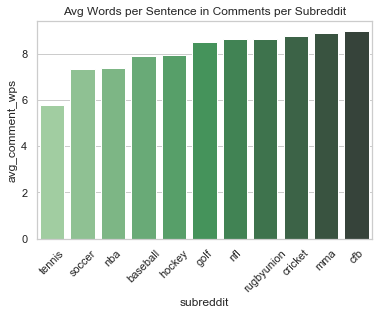

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid", color_codes=True)
pal = sns.color_palette("Greens_d", len(submission_df_pivot))
ax = sns.barplot(x="subreddit", 
                 y="avg_comment_wps", 
                 data=submission_df_pivot,
                 palette=np.array(pal[::-1]))
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title("Avg Words per Sentence in Comments per Subreddit")
plt.show()

#### Using Bokeh

In [32]:
from bokeh.io import show, output_file
from bokeh.plotting import figure

output_file("subreddit_wps.html")

subreddit = list(submission_df_pivot['subreddit'])
words_per_sentence = list(submission_df_pivot['avg_comment_wps'])

p = figure(x_range=subreddit, plot_height=250, title="Fruit words_per_sentence",
           toolbar_location=None, tools="")

p.vbar(x=subreddit, top=words_per_sentence, width=0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)

#### By time